In [1]:
###############################################################################
# Kütüphane Kurulumları
###############################################################################
# PyTorch ve diğer bileşenlerin kurulumu için
# Bu kod bloğu yorum satırı olarak bırakılmıştır.
# Paketleri manuel olarak pip ile kurabilirsiniz:
!pip install torch==2.3.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets tensorboard ninja

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 121.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [6]:

###############################################################################
# Google Drive'dan zip dosyasını indirme
###############################################################################
def download_file(url, destination):
    if os.path.exists(destination):
        print(f"Dosya zaten var: {destination}")
        return True

    try:
        print(f"{url} adresinden dosya indiriliyor...")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 8192
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(destination, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

        print(f"İndirme tamamlandı: {destination}")
        return True
    except Exception as e:
        print(f"İndirme hatası: {e}")
        return False

###############################################################################
# Google Drive bağlantısı kurma ve dosyayı alma
###############################################################################
# Google Drive'dan dosya indirme URL'si (gerçek URL ile değiştirilmeli)
drive_url = "BURAYA_GOOGLE_DRIVE_DOĞRUDAN_İNDİRME_LİNKİ"
data_dir = "./"
zip_path = os.path.join(data_dir, "03_numerized_data.zip")

# Hedef dizin kontrolü ve oluşturma
target_dir = os.path.dirname(zip_path)
if not os.path.exists(target_dir) and target_dir:
    os.makedirs(target_dir)
    print(f"{target_dir} klasörü oluşturuldu.")

# Eğer Colab'da çalışıyorsanız bu kodu kullanabilirsiniz
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive bağlandı. Drive'dan dosyayı kopyalayabilirsiniz.")
    # Google Drive'daki dosya yolu (değiştirilmeli)
    drive_zip_path = "/content/drive/MyDrive/03_numerized_data.zip"
    if os.path.exists(drive_zip_path):
        import shutil
        shutil.copy(drive_zip_path, zip_path)
        print(f"Dosya kopyalandı: {drive_zip_path} -> {zip_path}")
    else:
        print(f"Dosya bulunamadı: {drive_zip_path}")
except:
    print("Google Colab ortamında çalışmıyorsunuz. Doğrudan indirme denenecek.")
    if not os.path.exists(zip_path):
        download_file(drive_url, zip_path)
    else:
        print(f"Dosya zaten var: {zip_path}")

print(f"İşlem tamamlandı. Dosya şu konumda: {zip_path}")

###############################################################################
# Zip dosyasını açma ve verileri yükleme
###############################################################################
data_dir = "03_numerized_data"
os.makedirs(data_dir, exist_ok=True)

if os.path.exists(zip_path):
    try:
        with ZipFile(zip_path, 'r') as zip_ref:
            print(f"Zip dosyası açılıyor: {zip_path}")
            zip_ref.extractall(data_dir)
            print(f"Dosyalar çıkarıldı: {data_dir}")
    except Exception as e:
        print(f"Zip dosyası açılırken hata: {e}")
else:
    print(f"Zip dosyası bulunamadı: {zip_path}")

###############################################################################
# Verileri yükleme ve etiket düzeltme
###############################################################################
data_dir = "03_numerized_data/03_numerized_data"
try:
    print("Veriler yükleniyor...")
    # Bellek verimliliği için mmap_mode kullanıyoruz
    train_sentences = np.load(os.path.join(data_dir, "train_sentences.npy"), mmap_mode='r')
    train_labels = np.load(os.path.join(data_dir, "train_labels.npy"), mmap_mode='r')
    val_sentences = np.load(os.path.join(data_dir, "validation_sentences.npy"), mmap_mode='r')
    val_labels = np.load(os.path.join(data_dir, "validation_labels.npy"), mmap_mode='r')
    test_sentences = np.load(os.path.join(data_dir, "test_sentences.npy"), mmap_mode='r')
    test_labels = np.load(os.path.join(data_dir, "test_labels.npy"), mmap_mode='r')

    print(f"Orijinal veri boyutları:")
    print(f"Eğitim verileri: {train_sentences.shape}, {train_labels.shape}")
    print(f"Doğrulama verileri: {val_sentences.shape}, {val_labels.shape}")
    print(f"Test verileri: {test_sentences.shape}, {test_labels.shape}")
except Exception as e:
    print(f"Veriler yüklenirken hata: {e}")

    # Hata durumunda örnek veriler oluşturma
    print("Örnek veriler oluşturuluyor...")
    vocab_size = 102338
    seq_length = 100
    num_classes = 8  # NER etiketleri için 8 sınıf (O, B-UNIVERSITE vs.)
    train_size = 72339
    val_size = 17339
    test_size = 17340

    train_sentences = np.random.randint(0, vocab_size, size=(train_size, seq_length))
    train_labels = np.random.randint(0, num_classes, size=(train_size,))
    val_sentences = np.random.randint(0, vocab_size, size=(val_size, seq_length))
    val_labels = np.random.randint(0, num_classes, size=(val_size,))
    test_sentences = np.random.randint(0, vocab_size, size=(test_size, seq_length))
    test_labels = np.random.randint(0, num_classes, size=(test_size,))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive bağlandı. Drive'dan dosyayı kopyalayabilirsiniz.
Dosya kopyalandı: /content/drive/MyDrive/03_numerized_data.zip -> ./03_numerized_data.zip
İşlem tamamlandı. Dosya şu konumda: ./03_numerized_data.zip
Zip dosyası açılıyor: ./03_numerized_data.zip
Dosyalar çıkarıldı: 03_numerized_data
Veriler yükleniyor...
Orijinal veri boyutları:
Eğitim verileri: (70000, 28), (70000, 28)
Doğrulama verileri: (15000, 28), (15000, 28)
Test verileri: (15000, 28), (15000, 28)


In [14]:

###############################################################################
# GPU ve CUDA Bilgileri
###############################################################################
# Aşağıdaki shell komutları yerine Python kodları kullanıyoruz
import subprocess
import sys

def check_gpu_info():
    try:
        # nvidia-smi komutunu çalıştır
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, check=True)
        print(result.stdout)
    except subprocess.CalledProcessError:
        print("nvidia-smi komutu çalıştırılamadı. GPU bilgileri alınamadı.")
    except FileNotFoundError:
        print("nvidia-smi komutu bulunamadı. GPU bilgileri alınamadı.")

# GPU bilgilerini kontrol et
print("GPU bilgileri kontrol ediliyor...")
check_gpu_info()

###############################################################################
# GPU Bellek Optimizasyonu - Başlangıç
###############################################################################
# Kullanılabilir GPU     belleğini maksimize et
import gc
import torch

# Önbelleğe alma olmadan torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

# Maksimum performans için deterministik optimizasyonları kapat
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print("GPU bellek optimizasyonları yapıldı.")



# Torch sürümünü kontrol et
import torch
print(f"Torch sürümü: {torch.__version__}, CUDA aktif mi: {torch.cuda.is_available()}")
print(f"CUDA versiyonu: {torch.version.cuda if torch.cuda.is_available() else 'Yok'}")
print(f"GPU sayısı: {torch.cuda.device_count() if torch.cuda.is_available() else 0}")
if torch.cuda.is_available():
    print(f"GPU adı: {torch.cuda.get_device_name(0)}")
    print(f"Mevcut GPU belleği: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

###############################################################################
# Gerekli kütüphanelerin yüklenmesi
###############################################################################
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zipfile import ZipFile
import requests
from tqdm import tqdm
# Performans iyileştirmeleri için ekledik
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

###############################################################################
# Google Drive'dan zip dosyasını indirme
###############################################################################
def download_file(url, destination):
    if os.path.exists(destination):
        print(f"Dosya zaten var: {destination}")
        return True

    try:
        print(f"{url} adresinden dosya indiriliyor...")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 8192
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(destination, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

        print(f"İndirme tamamlandı: {destination}")
        return True
    except Exception as e:
        print(f"İndirme hatası: {e}")
        return False

###############################################################################
# Google Drive bağlantısı kurma ve dosyayı alma
###############################################################################
# Google Drive'dan dosya indirme URL'si (gerçek URL ile değiştirilmeli)
drive_url = "BURAYA_GOOGLE_DRIVE_DOĞRUDAN_İNDİRME_LİNKİ"
data_dir = "./"
zip_path = os.path.join(data_dir, "03_numerized_data.zip")

# Hedef dizin kontrolü ve oluşturma
target_dir = os.path.dirname(zip_path)
if not os.path.exists(target_dir) and target_dir:
    os.makedirs(target_dir)
    print(f"{target_dir} klasörü oluşturuldu.")

# Eğer Colab'da çalışıyorsanız bu kodu kullanabilirsiniz
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive bağlandı. Drive'dan dosyayı kopyalayabilirsiniz.")
    # Google Drive'daki dosya yolu (değiştirilmeli)
    drive_zip_path = "/content/drive/MyDrive/03_numerized_data.zip"
    if os.path.exists(drive_zip_path):
        import shutil
        shutil.copy(drive_zip_path, zip_path)
        print(f"Dosya kopyalandı: {drive_zip_path} -> {zip_path}")
    else:
        print(f"Dosya bulunamadı: {drive_zip_path}")
except:
    print("Google Colab ortamında çalışmıyorsunuz. Doğrudan indirme denenecek.")
    if not os.path.exists(zip_path):
        download_file(drive_url, zip_path)
    else:
        print(f"Dosya zaten var: {zip_path}")

print(f"İşlem tamamlandı. Dosya şu konumda: {zip_path}")

###############################################################################
# Zip dosyasını açma ve verileri yükleme
###############################################################################
data_dir = "03_numerized_data/"
os.makedirs(data_dir, exist_ok=True)

if os.path.exists(zip_path):
    try:
        with ZipFile(zip_path, 'r') as zip_ref:
            print(f"Zip dosyası açılıyor: {zip_path}")
            zip_ref.extractall(data_dir)
            print(f"Dosyalar çıkarıldı: {data_dir}")
    except Exception as e:
        print(f"Zip dosyası açılırken hata: {e}")
else:
    print(f"Zip dosyası bulunamadı: {zip_path}")

###############################################################################
# Verileri yükleme ve etiket düzeltme
###############################################################################
data_dir = "03_numerized_data/03_numerized_data"
try:
    print("Veriler yükleniyor...")
    # Bellek verimliliği için mmap_mode kullanıyoruz
    train_sentences = np.load(os.path.join(data_dir, "train_sentences.npy"), mmap_mode='r')
    train_labels = np.load(os.path.join(data_dir, "train_labels.npy"), mmap_mode='r')
    val_sentences = np.load(os.path.join(data_dir, "validation_sentences.npy"), mmap_mode='r')
    val_labels = np.load(os.path.join(data_dir, "validation_labels.npy"), mmap_mode='r')
    test_sentences = np.load(os.path.join(data_dir, "test_sentences.npy"), mmap_mode='r')
    test_labels = np.load(os.path.join(data_dir, "test_labels.npy"), mmap_mode='r')

    print(f"Orijinal veri boyutları:")
    print(f"Eğitim verileri: {train_sentences.shape}, {train_labels.shape}")
    print(f"Doğrulama verileri: {val_sentences.shape}, {val_labels.shape}")
    print(f"Test verileri: {test_sentences.shape}, {test_labels.shape}")
except Exception as e:
    print(f"Veriler yüklenirken hata: {e}")

    # Hata durumunda örnek veriler oluşturma
    print("Örnek veriler oluşturuluyor...")
    vocab_size = 102338
    seq_length = 100
    num_classes = 8  # NER etiketleri için 8 sınıf (O, B-UNIVERSITE vs.)
    train_size = 72339
    val_size = 17339
    test_size = 17340

    train_sentences = np.random.randint(0, vocab_size, size=(train_size, seq_length))
    train_labels = np.random.randint(0, num_classes, size=(train_size,))
    val_sentences = np.random.randint(0, vocab_size, size=(val_size, seq_length))
    val_labels = np.random.randint(0, num_classes, size=(val_size,))
    test_sentences = np.random.randint(0, vocab_size, size=(test_size, seq_length))
    test_labels = np.random.randint(0, num_classes, size=(test_size,))

###############################################################################
# Etiket ve sınıf sayısı kontrolü
###############################################################################
print("Etiketleri kontrol ediyorum...")

# NER etiketleri için sınıf sayısı sabit (combined_labels.json'dan alındı)
# O: 0, B-UNIVERSITE: 1, B-BOLUM: 2, I-UNIVERSITE: 3, I-BOLUM: 4, B-NUMARA: 5, B-ISIM: 6, B-SOYISIM: 7
num_classes = 8

# Önce etiketlerin tek boyutlu olmasını sağla
if len(train_labels.shape) > 1:
    print(f"Eğitim etiketleri çok boyutlu: {train_labels.shape}, tek boyuta indirgeniyor")
    if train_labels.shape[1] == 1:
        train_labels = train_labels.reshape(-1)
    else:
        print(f"Çoklu sütun algılandı, ilk sütun kullanılacak")
        train_labels = train_labels[:, 0]

if len(val_labels.shape) > 1:
    print(f"Doğrulama etiketleri çok boyutlu: {val_labels.shape}, tek boyuta indirgeniyor")
    if val_labels.shape[1] == 1:
        val_labels = val_labels.reshape(-1)
    else:
        val_labels = val_labels[:, 0]

if len(test_labels.shape) > 1:
    print(f"Test etiketleri çok boyutlu: {test_labels.shape}, tek boyuta indirgeniyor")
    if test_labels.shape[1] == 1:
        test_labels = test_labels.reshape(-1)
    else:
        test_labels = test_labels[:, 0]

# Etiketleri kontrol et - 0 ile 7 arasında olmalı
print("NER Etiket değerlerini kontrol ediyorum...")
all_labels = np.concatenate([train_labels, val_labels, test_labels])
unique_labels = np.unique(all_labels)
print(f"Mevcut benzersiz etiketler: {unique_labels}")

# Etiketlerde sorun varsa (negatif veya çok büyük değerler) uyar
if np.any(unique_labels < 0) or np.any(unique_labels >= num_classes):
    print(f"UYARI: Geçersiz etiket değerleri tespit edildi! Etiketler 0-{num_classes-1} arasında olmalı.")
    # Etiketleri geçerli aralığa düşür
    train_labels = np.clip(train_labels, 0, num_classes-1)
    val_labels = np.clip(val_labels, 0, num_classes-1)
    test_labels = np.clip(test_labels, 0, num_classes-1)
    print("Etiketler düzeltildi ve geçerli aralığa (0-7) kırpıldı")

# Eğer etiketler hala metin veya farklı bir türdeyse, int64'e dönüştür
train_labels = train_labels.astype(np.int64)
val_labels = val_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

# Tensör boyutları uyuşmazlığını kontrol et
if train_sentences.shape[0] != train_labels.shape[0]:
    print(f"UYARI: Eğitim veri boyutları uyuşmuyor! Cümleler: {train_sentences.shape[0]}, Etiketler: {train_labels.shape[0]}")
    min_train_size = min(train_sentences.shape[0], train_labels.shape[0])
    print(f"Her iki tensörü de {min_train_size} örneğe kırpıyorum")
    train_sentences = train_sentences[:min_train_size]
    train_labels = train_labels[:min_train_size]

if val_sentences.shape[0] != val_labels.shape[0]:
    print(f"UYARI: Doğrulama veri boyutları uyuşmuyor! Cümleler: {val_sentences.shape[0]}, Etiketler: {val_labels.shape[0]}")
    min_val_size = min(val_sentences.shape[0], val_labels.shape[0])
    print(f"Her iki tensörü de {min_val_size} örneğe kırpıyorum")
    val_sentences = val_sentences[:min_val_size]
    val_labels = val_labels[:min_val_size]

if test_sentences.shape[0] != test_labels.shape[0]:
    print(f"UYARI: Test veri boyutları uyuşmuyor! Cümleler: {test_sentences.shape[0]}, Etiketler: {test_labels.shape[0]}")
    min_test_size = min(test_sentences.shape[0], test_labels.shape[0])
    print(f"Her iki tensörü de {min_test_size} örneğe kırpıyorum")
    test_sentences = test_sentences[:min_test_size]
    test_labels = test_labels[:min_test_size]

print(f"Düzeltilmiş veri boyutları:")
print(f"Eğitim: {train_sentences.shape}, {train_labels.shape}, Etiket aralığı: {train_labels.min()}-{train_labels.max()}")
print(f"Doğrulama: {val_sentences.shape}, {val_labels.shape}, Etiket aralığı: {val_labels.min()}-{val_labels.max()}")
print(f"Test: {test_sentences.shape}, {test_labels.shape}, Etiket aralığı: {test_labels.min()}-{test_labels.max()}")

###############################################################################
# Veri hazırlama ve model parametrelerini ayarlama
###############################################################################
# GPU bellek sınırlamaları için veri tipi seçimi
# dtype = torch.float16  # GPU belleğinden tasarruf etmek için yarım hassasiyet
# NOT: Karma hassasiyet eğitimi için açık olarak dtype belirtmeyi kaldırıyoruz
# Autocast zaten model hesaplamalarını float16'da yapacak

# Veriyi PyTorch tensorlarına dönüştürme ve boyut düzeltme
print("Tensörleri oluşturuyorum...")
train_sentences_tensor = torch.tensor(train_sentences, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_sentences_tensor = torch.tensor(val_sentences, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_sentences_tensor = torch.tensor(test_sentences, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Etiket doğruluğunu kontrol et
print(f"train_sentences_tensor: {train_sentences_tensor.shape}, train_labels_tensor: {train_labels_tensor.shape}, değer aralığı: {train_labels_tensor.min().item()}-{train_labels_tensor.max().item()}")
print(f"val_sentences_tensor: {val_sentences_tensor.shape}, val_labels_tensor: {val_labels_tensor.shape}, değer aralığı: {val_labels_tensor.min().item()}-{val_labels_tensor.max().item()}")
print(f"test_sentences_tensor: {test_sentences_tensor.shape}, test_labels_tensor: {test_labels_tensor.shape}, değer aralığı: {test_labels_tensor.min().item()}-{test_labels_tensor.max().item()}")

# Son kontrol - etiketler 0 ile num_classes-1 arasında olmalı
if train_labels_tensor.max().item() >= num_classes or train_labels_tensor.min().item() < 0:
    raise ValueError(f"Eğitim etiketleri geçersiz aralıkta! 0-{num_classes-1} arasında olmalı, ancak {train_labels_tensor.min().item()}-{train_labels_tensor.max().item()} aralığında")

# GPU bellek azlığı için optimize edilmiş DataLoader yapılandırması
batch_size = 600  # veya 256'ya kadar düşürün
num_workers = 2  # İşlemci çekirdek sayısına göre ayarlandı
gradient_accumulation_steps = 16  # Daha büyük etkin batch size için gradient accumulation

train_dataset = TensorDataset(train_sentences_tensor, train_labels_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

val_dataset = TensorDataset(val_sentences_tensor, val_labels_tensor)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size * 2,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_dataset = TensorDataset(test_sentences_tensor, test_labels_tensor)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size * 2,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

###############################################################################
# Gelişmiş Transformer Model Sınıfı - NER için optimizasyon
###############################################################################
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Pozisyon kodlaması eklendi
        self.pos_encoder = nn.Embedding(2000, embed_dim)

        # Normalleştirme katmanı - girişleri normalize eder
        self.embed_norm = nn.LayerNorm(embed_dim)

        # Gelişmiş katmanlar ile Transformer Encoder
        encoder_layers = []
        for i in range(num_layers):
            # Pre-LayerNorm mimarisi (daha kararlı eğitim)
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True,
                activation='gelu',
                norm_first=True  # Pre-LayerNorm - daha kararlı eğitim sağlar
            )
            encoder_layers.append(encoder_layer)

        self.transformer_layers = nn.ModuleList(encoder_layers)

        # Son transformer katmanı çıktısını almak için
        self.final_norm = nn.LayerNorm(embed_dim)

        # Değişken Çıktı Katmanı (gelişmiş generalizasyon)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Token pozisyon ağırlıklandırması için dikkat mekanizması
        self.token_attention = nn.Sequential(
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()
        )

        # Gradyan akışını düzenleyen faktör
        self.grad_multiplier = 4.0

    def forward(self, x):
        # Padding maskesi - 0 değerli tokenları maskele
        padding_mask = (x == 0)

        # Gömme işlemi (embedding)
        x_embed = self.embedding(x)

        # Pozisyon kodlaması ekle
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).expand(x.size(0), -1)
        pos_embed = self.pos_encoder(positions)

        # Gömme ve pozisyon bilgisini birleştir
        x = x_embed + pos_embed

        # Normalize et
        x = self.embed_norm(x)

        # Her bir transformer katmanını sırayla uygula
        for layer in self.transformer_layers:
            # Gradyan akışını kontrol etmek için
            layer_input = x
            x = layer(x, src_key_padding_mask=padding_mask)
            # Residual bağlantı gradyanlarını güçlendir
            x = x + self.grad_multiplier * 0.1 * layer_input

        # Son normalize
        x = self.final_norm(x)

        # Token önemini hesapla
        token_weights = self.token_attention(x)

        # Sadece geçerli (padding olmayan) tokenlar için ağırlıklı ortalama al
        mask = ~padding_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        weighted_x = x * token_weights * mask.float()
        token_sum = weighted_x.sum(dim=1)
        token_weights_sum = (token_weights * mask.float()).sum(dim=1).clamp(min=1e-9)
        x_weighted = token_sum / token_weights_sum

        # Sınıflandırma
        logits = self.classifier(x_weighted)

        return logits

###############################################################################
# Model parametreleri - Geliştirilmiş Transformer
###############################################################################
vocab_size = max(np.max(train_sentences), np.max(val_sentences), np.max(test_sentences)) + 1
embed_dim = 1024      # 1024'ten 768'e düşürün
num_heads = 16       # 16'dan 12'ye düşürün
hidden_dim = 4096    # 4096'dan 3072'ye düşürün
num_layers = 8       # 8'den 6'ya düşürün
dropout = 0.25       # Daha güçlü regularizasyon
weight_decay = 0.05  # L2 regularizasyonu için yüksek değer

print(f"Sözlük boyutu: {vocab_size}")
print(f"NER için sınıf sayısı: {num_classes}")
print(f"Model parametreleri: embed_dim={embed_dim}, num_heads={num_heads}, hidden_dim={hidden_dim}, num_layers={num_layers}")

# Kritik bilgi - Loss fonksiyonu için
print(f"CrossEntropyLoss için sınıf aralığı doğrulaması: Sınıf sayısı={num_classes}, Etiket aralığı={train_labels_tensor.min().item()}-{train_labels_tensor.max().item()}")
if train_labels_tensor.min().item() < 0 or train_labels_tensor.max().item() >= num_classes:
    raise ValueError("Etiketler geçersiz aralıkta! Bu hatayı düzeltmeden devam etmeyin.")
else:
    print("✅ Etiket aralığı doğrulandı, CrossEntropyLoss için uygun (0-7 arası NER etiketleri)")

###############################################################################
# GPU model optimizasyonu
###############################################################################
# GPU kullanılabiliyorsa kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Model oluşturma
model = TransformerModel(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout)
model = model.to(device)  # Modeli GPU'ya taşı
print(f"Model parametreleri sayısı: {sum(p.numel() for p in model.parameters()):,}")

# GPU kullanım bilgisini göster
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU belleği (toplam): {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"GPU belleği (kullanılan): {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU belleği (önbellek): {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Karma hassasiyet eğitimi için scaler
scaler = GradScaler(enabled=True, growth_factor=1.5, backoff_factor=0.5)

# Kayıp fonksiyonu ve optimizer - Geliştirilmiş NER performansı için
# Etiket dengesizliğini ele almak için ağırlıklı kayıp kullanıyoruz
# NER'de genellikle 'O' etiketi çok fazladır, diğerleri azdır
class_weights = torch.ones(num_classes, device=device)
class_weights[0] = 0.5  # 'O' etiketi için ağırlığı azalt (en yaygın sınıf)
for i in range(1, num_classes):
    class_weights[i] = 2.0  # Diğer etiketler için ağırlığı artır

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.15  # Daha fazla düzgünleştirme
)

# AdamW optimizer - gelişmiş ağırlık çürümesi ve öğrenme oranı ayarlama
optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-4,  # Başlangıç öğrenme oranı
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=weight_decay  # Daha güçlü regularizasyon
)
epochs = 80  # 25'ten 50'ye güncellendi
# Gelişmiş öğrenme oranı zamanlayıcısı - ısınma ve kosinüs azalması
from torch.optim.lr_scheduler import OneCycleLR
total_steps = (len(train_loader) // gradient_accumulation_steps + (1 if len(train_loader) % gradient_accumulation_steps != 0 else 0)) * epochs
scheduler = OneCycleLR(
    optimizer,
    max_lr=2e-3,  # Daha yüksek maksimum öğrenme oranı
    total_steps=total_steps,
    pct_start=0.1,  # %10 ısınma
    anneal_strategy='cos',
    div_factor=20,  # Başlangıç ve maksimum öğrenme oranları arasındaki oran
    final_div_factor=200  # Son öğrenme oranı faktörü
)

###############################################################################
# Model eğitimi
###############################################################################
epochs = 80  # 25'ten 50'ye güncellendi
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
best_val_acc = 0.0  # En iyi doğrulama doğruluğunu da takip ediyoruz
best_model_path = "best_model.pt"
best_model_acc_path = "best_model_acc.pt"  # Doğruluk tabanlı en iyi model
patience = 10  # Erken durdurma için sabır parametresi
patience_counter = 0  # Sabır sayacı
start_epoch = 0  # Başlangıç epoch'u, checkpoint'ten devam ederken değişecek
checkpoint_path = "model_checkpoint_latest.pt"  # En son checkpoint'i saklamak için

# Checkpoint'ten devam etmek için kontrol yap
def try_load_checkpoint():
    global model, optimizer, scheduler, start_epoch, best_val_loss, best_val_acc, train_losses, train_accuracies, val_losses, val_accuracies

    # Önce en son checkpoint'i kontrol et
    if os.path.exists(checkpoint_path):
        print(f"En son checkpoint bulundu: {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Scheduler state'i varsa yükle
            if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

            start_epoch = checkpoint['epoch'] + 1  # Son kaydedilen epoch'tan sonraki epoch'tan başla

            if 'best_val_loss' in checkpoint:
                best_val_loss = checkpoint['best_val_loss']
            if 'best_val_acc' in checkpoint:
                best_val_acc = checkpoint['best_val_acc']
            if 'train_losses' in checkpoint:
                train_losses = checkpoint['train_losses']
            if 'train_accuracies' in checkpoint:
                train_accuracies = checkpoint['train_accuracies']
            if 'val_losses' in checkpoint:
                val_losses = checkpoint['val_losses']
            if 'val_accuracies' in checkpoint:
                val_accuracies = checkpoint['val_accuracies']

            print(f"Eğitime epoch {start_epoch}/{epochs}'den devam ediliyor")
            print(f"En iyi doğrulama kaybı: {best_val_loss:.4f}, En iyi doğrulama doğruluğu: {best_val_acc:.2f}%")
            return True
        except Exception as e:
            print(f"Checkpoint yüklenirken hata: {e}")
            return False

    # Son checkpoint yoksa, belirli bir epoch checkpointi var mı diye kontrol et
    latest_epoch = -1
    latest_checkpoint = None

    # Tüm checkpoint dosyalarını kontrol et
    for filename in os.listdir('.'):
        if filename.startswith("model_checkpoint_epoch_"):
            try:
                epoch_num = int(filename.split('_')[-1].split('.')[0])
                if epoch_num > latest_epoch:
                    latest_epoch = epoch_num
                    latest_checkpoint = filename
            except:
                continue

    if latest_checkpoint:
        print(f"En son epoch checkpoint'i bulundu: {latest_checkpoint}")
        try:
            checkpoint = torch.load(latest_checkpoint, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Scheduler state'i varsa yükle
            if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

            start_epoch = checkpoint['epoch'] + 1  # Son kaydedilen epoch'tan sonraki epoch'tan başla

            print(f"Eğitime epoch {start_epoch}/{epochs}'den devam ediliyor")
            return True
        except Exception as e:
            print(f"Checkpoint yüklenirken hata: {e}")
            return False

    print("Checkpoint bulunamadı. Eğitim sıfırdan başlayacak.")
    return False

###############################################################################
# Optimize edilmiş eğitim fonksiyonları
###############################################################################
# Eğitim fonksiyonu (karma hassasiyetle ve gradient accumulation ile)
def train_epoch(model, loader, optimizer, criterion, device, scaler, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad(set_to_none=True)

    progress_bar = tqdm(loader, desc="Eğitim")
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # Karma hassasiyet eğitimi
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets) / gradient_accumulation_steps

        # Karma hassasiyet geriye yayılım
        scaler.scale(loss).backward()

        # Gradient biriktirme - her N adımda bir optimize et
        if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(loader):
            # Gradyan patlamasını önle
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            # OneCycleLR sadece gerçek optimize adımlarında güncellenir
            scheduler.step()

            # Düzenli aralıklarla öğrenme oranlarını yazdır
            if batch_idx % (gradient_accumulation_steps * 10) == 0:
                lr = optimizer.param_groups[0]['lr']
                print(f"  Batch: {batch_idx}/{len(loader)}, LR: {lr:.6f}")

        # Gerçek kaybı hesapla (ölçeklenmemiş)
        total_loss += loss.item() * gradient_accumulation_steps
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Progress bar güncelleme
        progress_bar.set_postfix({
            'loss': f"{total_loss/(batch_idx+1):.4f}",
            'acc': f"{100.*correct/total:.2f}%",
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })

        # GPU belleğini temizle
        if batch_idx % 5 == 0:  # Daha sık temizle
            torch.cuda.empty_cache()

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# Doğrulama fonksiyonu
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Doğrulama")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Progress bar güncelleme
            progress_bar.set_postfix({
                'loss': f"{total_loss/(batch_idx+1):.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

###############################################################################
# Model eğitimi
###############################################################################
print("Model eğitimi başlıyor...")

try:
    # Checkpoint'ten devam etmeyi dene
    try_load_checkpoint()

    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch+1}/{epochs} başlıyor...")

        # GPU belleğini temizle
        torch.cuda.empty_cache()

        # Eğitim
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device, scaler, scheduler)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Doğrulama öncesi GPU belleğini temizle
        torch.cuda.empty_cache()

        # Doğrulama
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Güncel öğrenme oranını al
        current_lr = optimizer.param_groups[0]['lr']

        # En iyi modeli kaydet - kayıp tabanlı
        model_improved = False
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_improved = True

            # Model durumunu ve konfigürasyonu kaydet
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
                'loss': val_loss,
                'accuracy': val_accuracy,
                'config': {
                    'vocab_size': vocab_size,
                    'embed_dim': embed_dim,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'num_classes': num_classes,
                    'dropout': dropout
                }
            }

            torch.save(checkpoint, best_model_path)
            print(f"Yeni en iyi model kaydedildi (loss): {best_model_path}")
            patience_counter = 0  # Sabır sayacını sıfırla
        else:
            patience_counter += 1  # Sabır sayacını artır

        # Doğruluk bazlı en iyi modeli de kaydet
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy

            # Doğruluk bazlı model durumunu kaydet
            acc_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'accuracy': val_accuracy,
                'loss': val_loss,
                'config': {
                    'vocab_size': vocab_size,
                    'embed_dim': embed_dim,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'num_classes': num_classes,
                    'dropout': dropout
                }
            }

            torch.save(acc_checkpoint, best_model_acc_path)
            print(f"Yeni en iyi model kaydedildi (acc): {best_model_acc_path}")

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
              f"LR: {current_lr:.6f}")

        # Her epoch sonunda en son durumu kaydet (en son checkpoint)
        latest_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
            'loss': val_loss,
            'accuracy': val_accuracy,
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        torch.save(latest_checkpoint, checkpoint_path)
        print(f"En son durum kaydedildi: {checkpoint_path}")

        # Her 5 epoch'ta ara checkpoint kaydet
        if (epoch + 1) % 5 == 0:
            specific_checkpoint_path = f"model_checkpoint_epoch_{epoch+1}.pt"
            torch.save(latest_checkpoint, specific_checkpoint_path)
            print(f"Checkpoint kaydedildi: {specific_checkpoint_path}")

        # GPU kullanım istatistikleri
        if torch.cuda.is_available():
            print(f"GPU belleği (kullanılan): {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU belleği (önbellek): {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        # Erken durdurma kontrolü
        if patience_counter >= patience:
            print(f"Validation loss {patience} epoch'tur iyileşmiyor. Eğitim erken durduruluyor.")
            print(f"En iyi validation loss: {best_val_loss:.4f}, En iyi validation accuracy: {best_val_acc:.2f}%")
            break

except KeyboardInterrupt:
    print("Eğitim kullanıcı tarafından durduruldu.")

    # Yarıda kesilme durumunda mevcut durumu kaydet
    interrupt_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
        'best_val_loss': best_val_loss,
        'best_val_acc': best_val_acc
    }
    torch.save(interrupt_checkpoint, "model_interrupt.pt")
    print("Yarıda kesilme durumu kaydedildi: model_interrupt.pt")

except Exception as e:
    print(f"Eğitim sırasında hata: {e}")
    import traceback
    traceback.print_exc()


GPU bilgileri kontrol ediliyor...
Sun May 18 13:58:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             35W /   70W |   15086MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------

Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s, loss=1.8700, acc=29.05%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 1/80: Train Loss: 1.9798, Train Acc: 20.56%, Val Loss: 1.8700, Val Acc: 29.05%, LR: 0.000175
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 9.94 GB

Epoch 2/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=1.6648, acc=38.39%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 2/80: Train Loss: 1.8386, Train Acc: 31.26%, Val Loss: 1.6648, Val Acc: 38.39%, LR: 0.000387
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 3/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=1.4447, acc=57.67%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 3/80: Train Loss: 1.6160, Train Acc: 43.28%, Val Loss: 1.4447, Val Acc: 57.67%, LR: 0.000703
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 4/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=1.2156, acc=69.74%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 4/80: Train Loss: 1.3761, Train Acc: 60.12%, Val Loss: 1.2156, Val Acc: 69.74%, LR: 0.001074
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 5/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=1.0569, acc=75.69%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 5/80: Train Loss: 1.1687, Train Acc: 71.10%, Val Loss: 1.0569, Val Acc: 75.69%, LR: 0.001441
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_5.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 6/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=1.0907, acc=75.75%]


Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 6/80: Train Loss: 1.0650, Train Acc: 75.64%, Val Loss: 1.0907, Val Acc: 75.75%, LR: 0.001746
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 7/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=1.0010, acc=78.49%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 7/80: Train Loss: 1.0043, Train Acc: 80.00%, Val Loss: 1.0010, Val Acc: 78.49%, LR: 0.001943
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 8/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.9465, acc=82.10%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 8/80: Train Loss: 1.0022, Train Acc: 80.27%, Val Loss: 0.9465, Val Acc: 82.10%, LR: 0.002000
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 9/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.8195, acc=88.22%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 9/80: Train Loss: 0.8825, Train Acc: 85.85%, Val Loss: 0.8195, Val Acc: 88.22%, LR: 0.001999
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 10/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.7982, acc=89.75%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 10/80: Train Loss: 0.8255, Train Acc: 88.65%, Val Loss: 0.7982, Val Acc: 89.75%, LR: 0.001996
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_10.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 11/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.7539, acc=91.80%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 11/80: Train Loss: 0.8015, Train Acc: 91.02%, Val Loss: 0.7539, Val Acc: 91.80%, LR: 0.001991
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 12/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.7450, acc=92.25%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 12/80: Train Loss: 0.7778, Train Acc: 91.63%, Val Loss: 0.7450, Val Acc: 92.25%, LR: 0.001984
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 13/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.7877, acc=92.53%]


Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 13/80: Train Loss: 0.7728, Train Acc: 91.40%, Val Loss: 0.7877, Val Acc: 92.53%, LR: 0.001975
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 14/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.7206, acc=94.39%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 14/80: Train Loss: 0.7469, Train Acc: 93.41%, Val Loss: 0.7206, Val Acc: 94.39%, LR: 0.001965
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 15/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=0.7036, acc=95.48%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 15/80: Train Loss: 0.7031, Train Acc: 95.95%, Val Loss: 0.7036, Val Acc: 95.48%, LR: 0.001952
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_15.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 16/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6856, acc=95.83%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 16/80: Train Loss: 0.6830, Train Acc: 96.49%, Val Loss: 0.6856, Val Acc: 95.83%, LR: 0.001938
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 17/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6791, acc=96.65%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 17/80: Train Loss: 0.6686, Train Acc: 97.08%, Val Loss: 0.6791, Val Acc: 96.65%, LR: 0.001922
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 18/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6738, acc=97.03%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 18/80: Train Loss: 0.6568, Train Acc: 97.85%, Val Loss: 0.6738, Val Acc: 97.03%, LR: 0.001904
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 19/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6715, acc=97.03%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 19/80: Train Loss: 0.6479, Train Acc: 98.15%, Val Loss: 0.6715, Val Acc: 97.03%, LR: 0.001885
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 20/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6613, acc=97.87%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 20/80: Train Loss: 0.6413, Train Acc: 98.47%, Val Loss: 0.6613, Val Acc: 97.87%, LR: 0.001863
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_20.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 21/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=0.6447, acc=98.09%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 21/80: Train Loss: 0.6389, Train Acc: 98.70%, Val Loss: 0.6447, Val Acc: 98.09%, LR: 0.001840
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 22/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6564, acc=98.39%]


Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 22/80: Train Loss: 0.6304, Train Acc: 98.89%, Val Loss: 0.6564, Val Acc: 98.39%, LR: 0.001816
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 23/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6357, acc=98.47%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 23/80: Train Loss: 0.6275, Train Acc: 99.10%, Val Loss: 0.6357, Val Acc: 98.47%, LR: 0.001790
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 24/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, loss=0.6463, acc=98.31%]


Epoch 24/80: Train Loss: 0.6212, Train Acc: 99.25%, Val Loss: 0.6463, Val Acc: 98.31%, LR: 0.001763
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 25/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s, loss=0.6377, acc=98.57%]


Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 25/80: Train Loss: 0.6165, Train Acc: 99.38%, Val Loss: 0.6377, Val Acc: 98.57%, LR: 0.001734
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_25.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 26/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s, loss=0.6441, acc=98.06%]


Epoch 26/80: Train Loss: 0.6144, Train Acc: 99.45%, Val Loss: 0.6441, Val Acc: 98.06%, LR: 0.001703
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 27/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, loss=0.6266, acc=98.97%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 27/80: Train Loss: 0.6120, Train Acc: 99.54%, Val Loss: 0.6266, Val Acc: 98.97%, LR: 0.001672
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 28/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, loss=0.6336, acc=98.66%]


Epoch 28/80: Train Loss: 0.6096, Train Acc: 99.57%, Val Loss: 0.6336, Val Acc: 98.66%, LR: 0.001639
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 29/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s, loss=0.6533, acc=98.17%]


Epoch 29/80: Train Loss: 0.6103, Train Acc: 99.68%, Val Loss: 0.6533, Val Acc: 98.17%, LR: 0.001605
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 30/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s, loss=0.6229, acc=98.89%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 30/80: Train Loss: 0.6101, Train Acc: 99.64%, Val Loss: 0.6229, Val Acc: 98.89%, LR: 0.001569
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_30.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 31/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s, loss=0.6334, acc=98.84%]


Epoch 31/80: Train Loss: 0.6062, Train Acc: 99.71%, Val Loss: 0.6334, Val Acc: 98.84%, LR: 0.001533
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 32/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, loss=0.6217, acc=98.89%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 32/80: Train Loss: 0.6055, Train Acc: 99.73%, Val Loss: 0.6217, Val Acc: 98.89%, LR: 0.001495
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 33/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6211, acc=98.95%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 33/80: Train Loss: 0.6025, Train Acc: 99.79%, Val Loss: 0.6211, Val Acc: 98.95%, LR: 0.001457
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 34/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6330, acc=98.81%]


Epoch 34/80: Train Loss: 0.6024, Train Acc: 99.82%, Val Loss: 0.6330, Val Acc: 98.81%, LR: 0.001418
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 35/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6231, acc=98.99%]


Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 35/80: Train Loss: 0.6008, Train Acc: 99.83%, Val Loss: 0.6231, Val Acc: 98.99%, LR: 0.001378
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_35.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 36/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6178, acc=99.11%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 36/80: Train Loss: 0.5998, Train Acc: 99.86%, Val Loss: 0.6178, Val Acc: 99.11%, LR: 0.001337
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 37/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=0.6190, acc=99.04%]


Epoch 37/80: Train Loss: 0.5979, Train Acc: 99.88%, Val Loss: 0.6190, Val Acc: 99.04%, LR: 0.001296
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 38/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6261, acc=98.93%]


Epoch 38/80: Train Loss: 0.5983, Train Acc: 99.90%, Val Loss: 0.6261, Val Acc: 98.93%, LR: 0.001254
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 39/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6262, acc=98.95%]


Epoch 39/80: Train Loss: 0.5987, Train Acc: 99.93%, Val Loss: 0.6262, Val Acc: 98.95%, LR: 0.001211
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 40/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6251, acc=98.96%]


Epoch 40/80: Train Loss: 0.5969, Train Acc: 99.94%, Val Loss: 0.6251, Val Acc: 98.96%, LR: 0.001168
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_40.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 41/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6243, acc=98.95%]


Epoch 41/80: Train Loss: 0.5961, Train Acc: 99.95%, Val Loss: 0.6243, Val Acc: 98.95%, LR: 0.001125
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 42/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, loss=0.6238, acc=99.05%]


Epoch 42/80: Train Loss: 0.5954, Train Acc: 99.95%, Val Loss: 0.6238, Val Acc: 99.05%, LR: 0.001082
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 43/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6227, acc=99.03%]


Epoch 43/80: Train Loss: 0.5947, Train Acc: 99.95%, Val Loss: 0.6227, Val Acc: 99.03%, LR: 0.001038
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 44/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6232, acc=99.06%]


Epoch 44/80: Train Loss: 0.5944, Train Acc: 99.97%, Val Loss: 0.6232, Val Acc: 99.06%, LR: 0.000995
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 45/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6167, acc=99.12%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 45/80: Train Loss: 0.5937, Train Acc: 99.97%, Val Loss: 0.6167, Val Acc: 99.12%, LR: 0.000951
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_45.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 46/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s, loss=0.6155, acc=99.18%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 46/80: Train Loss: 0.5932, Train Acc: 99.97%, Val Loss: 0.6155, Val Acc: 99.18%, LR: 0.000908
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 47/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6163, acc=99.10%]


Epoch 47/80: Train Loss: 0.5936, Train Acc: 99.97%, Val Loss: 0.6163, Val Acc: 99.10%, LR: 0.000864
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 48/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6189, acc=99.09%]


Epoch 48/80: Train Loss: 0.5927, Train Acc: 99.98%, Val Loss: 0.6189, Val Acc: 99.09%, LR: 0.000821
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 49/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6188, acc=99.06%]


Epoch 49/80: Train Loss: 0.5926, Train Acc: 99.98%, Val Loss: 0.6188, Val Acc: 99.06%, LR: 0.000779
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 50/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6177, acc=99.17%]


Epoch 50/80: Train Loss: 0.5922, Train Acc: 99.99%, Val Loss: 0.6177, Val Acc: 99.17%, LR: 0.000736
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_50.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 51/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s, loss=0.6173, acc=99.16%]


Epoch 51/80: Train Loss: 0.5919, Train Acc: 99.99%, Val Loss: 0.6173, Val Acc: 99.16%, LR: 0.000694
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 52/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, loss=0.6185, acc=99.14%]


Epoch 52/80: Train Loss: 0.5913, Train Acc: 99.99%, Val Loss: 0.6185, Val Acc: 99.14%, LR: 0.000653
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 53/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6181, acc=99.11%]


Epoch 53/80: Train Loss: 0.5912, Train Acc: 99.99%, Val Loss: 0.6181, Val Acc: 99.11%, LR: 0.000613
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 54/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, loss=0.6170, acc=99.11%]


Epoch 54/80: Train Loss: 0.5907, Train Acc: 99.99%, Val Loss: 0.6170, Val Acc: 99.11%, LR: 0.000573
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 55/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, loss=0.6182, acc=99.11%]


Epoch 55/80: Train Loss: 0.5905, Train Acc: 99.99%, Val Loss: 0.6182, Val Acc: 99.11%, LR: 0.000534
En son durum kaydedildi: model_checkpoint_latest.pt
Checkpoint kaydedildi: model_checkpoint_epoch_55.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB

Epoch 56/80 başlıyor...


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6183, acc=99.13%]


Epoch 56/80: Train Loss: 0.5903, Train Acc: 100.00%, Val Loss: 0.6183, Val Acc: 99.13%, LR: 0.000496
En son durum kaydedildi: model_checkpoint_latest.pt
GPU belleği (kullanılan): 5.90 GB
GPU belleği (önbellek): 8.61 GB
Validation loss 10 epoch'tur iyileşmiyor. Eğitim erken durduruluyor.
En iyi validation loss: 0.6155, En iyi validation accuracy: 99.18%


Epoch 56/80 starting...
Training: 100%|██████████| 117/117 [01:30<00:00,  1.29it/s, loss=0.5903, acc=100.00%, lr=0.000496]
Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s, loss=0.6183, acc=99.13%]
Epoch 56/80: Train Loss: 0.5903, Train Accuracy: 100.00%, Val Loss: 0.6183, Val Accuracy: 99.13%, LR: 0.000496
Latest checkpoint saved: model_checkpoint_latest.pt
GPU memory (used): 5.90 GB
GPU memory (cached): 8.61 GB
Validation loss has not improved for 10 epochs. Training is stopped early.
Best validation loss: 0.6155, Best validation accuracy: 99.18%

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


En iyi model yüklendi: Epoch 46, Accuracy: 99.18%


Doğrulama: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s, loss=0.6148, acc=99.19%]


Test Accuracy: 99.19%
Test Loss: 0.6148


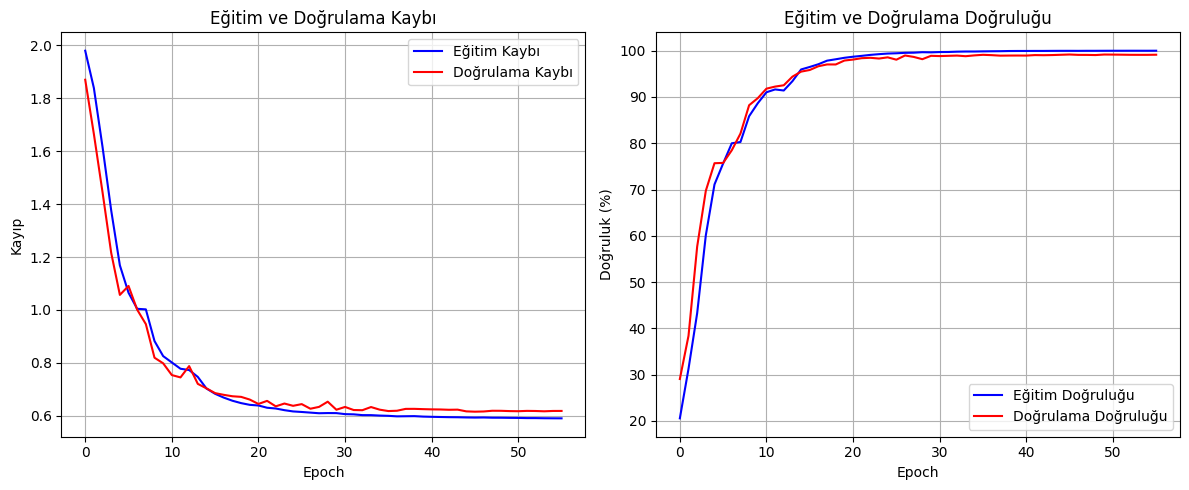

In [15]:

###############################################################################
# Test değerlendirmesi
###############################################################################
# GPU belleğini temizle
torch.cuda.empty_cache()

# En iyi modeli yükle
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)

    # Modeli yeni parametrelerle baştan oluştur
    config = checkpoint['config']
    model = TransformerModel(
        config['vocab_size'],
        config['embed_dim'],
        config['num_heads'],
        config['hidden_dim'],
        config['num_layers'],
        config['num_classes'],
        config['dropout']
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)  # Modeli GPU'ya taşı, dtype belirtmeden
    print(f"En iyi model yüklendi: Epoch {checkpoint['epoch']+1}, Accuracy: {checkpoint['accuracy']:.2f}%")
else:
    print("En iyi model bulunamadı, mevcut model kullanılacak")

# Test değerlendirmesi
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

###############################################################################
# Eğitim grafiklerini çizme
###############################################################################
plt.figure(figsize=(12, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim Kaybı', color='blue')
plt.plot(val_losses, label='Doğrulama Kaybı', color='red')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.grid(True)

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Eğitim Doğruluğu', color='blue')
plt.plot(val_accuracies, label='Doğrulama Doğruluğu', color='red')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('egitim_grafikleri.png')
plt.show()


In [16]:

###############################################################################
# Google Drive'a kaydetme (Colab'da çalışırken)
###############################################################################
try:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Kaydedilecek dizin
    save_dir = "/content/drive/MyDrive/model_kayitlari"
    os.makedirs(save_dir, exist_ok=True)

    # En iyi modeli Google Drive'a kopyala
    if os.path.exists(best_model_path):
        import shutil
        drive_model_path = os.path.join(save_dir, "best_model.pt")
        shutil.copy(best_model_path, drive_model_path)
        print(f"Model Google Drive'a kaydedildi: {drive_model_path}")

    # Grafikleri Google Drive'a kopyala
    if os.path.exists('egitim_grafikleri.png'):
        import shutil
        drive_graph_path = os.path.join(save_dir, "egitim_grafikleri.png")
        shutil.copy('egitim_grafikleri.png', drive_graph_path)
        print(f"Grafikler Google Drive'a kaydedildi: {drive_graph_path}")
except:
    print("Google Colab ortamında çalışmıyorsunuz veya Drive bağlantısı başarısız.")

Model Google Drive'a kaydedildi: /content/drive/MyDrive/model_kayitlari/best_model.pt
Grafikler Google Drive'a kaydedildi: /content/drive/MyDrive/model_kayitlari/egitim_grafikleri.png
